In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Related materials:
* Video notebook: https://github.com/fastai/course22/blob/master/04-how-does-a-neural-net-really-work.ipynb

In [86]:
! pip install fastbook

In [87]:
import numpy as np
import torch
from fastbook import plot_function
from matplotlib import pyplot as plt
from ipywidgets import interact
from fastai.basics import *
from numpy.random import normal, seed, uniform
from functools import partial

## Create a general quadratic function

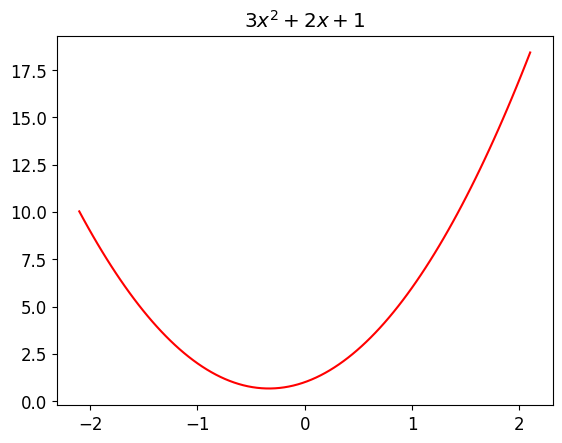

In [88]:
def f(x):
    return 3*x**2 + 2*x +1

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)
        
plot_function(f, title="$3x^2 + 2x + 1$")

In [89]:
# If we fix some particular values of a, b, and c, then we'll have made a quadratic. To fix values passed to a function in python, we use the partial function
def mk_quad(a,b,c):
    return partial(quad,a,b,c) # pass in a function, and fix the value of a b c

In [90]:
f = mk_quad(3,2,1)

In [91]:
f(1.5)

10.75

## Simulate the dataset we need to fit


In [92]:
np.random.seed(42)
def noise(x,scale):
    return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add):
    return x*(1+noise(x,mult)) + noise(x,add)

In [93]:
x = torch.linspace(-2, 2, steps = 20)[:, None] # this creates a tensor, a vector, from -2 to 2 on x-axis, in equal steps show 20 noise dots
print(x)

tensor([[-2.0000],
        [-1.7895],
        [-1.5789],
        [-1.3684],
        [-1.1579],
        [-0.9474],
        [-0.7368],
        [-0.5263],
        [-0.3158],
        [-0.1053],
        [ 0.1053],
        [ 0.3158],
        [ 0.5263],
        [ 0.7368],
        [ 0.9474],
        [ 1.1579],
        [ 1.3684],
        [ 1.5789],
        [ 1.7895],
        [ 2.0000]])


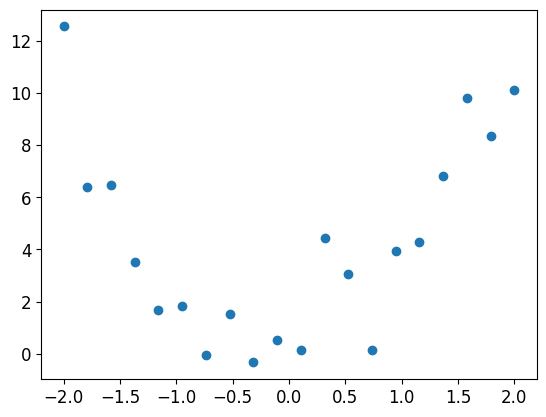

In [94]:
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x,y)

## Fit a function by good hands and eyes

In [95]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    plt.scatter(x, y)
    plot_function(mk_quad(a, b, c), ylim=(-3,12))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

## Fit a function by measuring loss function

In [96]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

In [97]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

## Automatically calculate the best fit with the least lost
A less manual way is to calculate the derivative, which tells us do we move it up or down and by how much.

In [98]:
# Takes the coefficients of the quadratic function as parameters, calculate mean absolute error -- which is the distance from each data point to the curve:
def quad_mae(params):
    f = mk_quad(*params) # *takes the parameters and spread them into a, b, c
    return mae(f(x), y)

In [99]:
quad_mae([1.5, 1.5, 1.5]) # when a, b, c equals to 1.5, what's the mae

tensor(1.6302, dtype=torch.float64)

In [100]:
abc=torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_() # ask pytorch to calculate the gradient

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [101]:
loss = quad_mae(abc)
loss

tensor(1.6302, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [102]:
loss.backward() # To get PyTorch to now calculate the gradients. The gradients will be stored for us in an attribute called grad.

In [103]:
abc.grad

tensor([-0.2748,  0.4421,  0.0000])

tensor([-9.2440, -1.5064, -4.3925]) means:

increase a by 1, loss goes down -9.2440

increase b by 1, loss goes down -1.5064

increase c by 1, loss goes down -4.3925


In [104]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)
    
print(f'loss={loss:.2f}')

loss=1.63


In [105]:
for i in range(5):
    loss = quad_mae(abc) # calculate the loss
    loss.backward() # calculate the gradient
    with torch.no_grad():
        abc -= abc.grad*0.01 # subtract the gradient
    print(f'step={i}; loss={loss:.2f}')

# the loss is to measure how far the current abc function is away from the dataset
# the gradient indicates to which direction we need to move a, b, c and how much do we move it

step=0; loss=1.63
step=1; loss=1.62
step=2; loss=1.61
step=3; loss=1.60
step=4; loss=1.59


In [106]:
abc

tensor([1.5577, 1.4072, 1.5000], requires_grad=True)

## ReLu function

In [107]:
def rectified_linear(m, b, x):
    y = m*x+b
    return torch.clip(y,0.) # returns y if y >0, else it returns 0

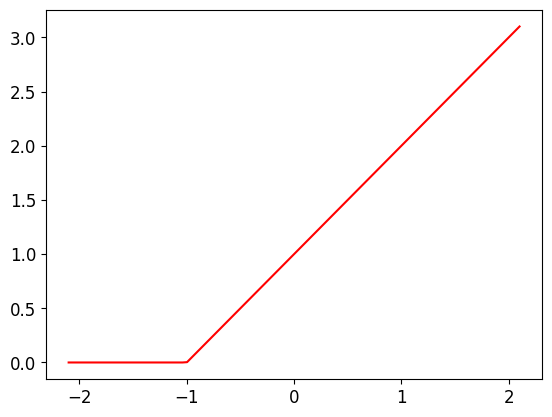

In [108]:
plot_function(partial(rectified_linear, 1, 1))

In [109]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [110]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))


interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

This is double-relu. We can add as many relu as we want, so that we can have an arbirarily squiggly function. With enough relu,we can much the function to the dataset as closely as we want.

matrix multiplication

http://matrixmultiplication.xyz/